In [1]:
import os

os.environ["MKL_NUM_THREADS"] = "4"
os.environ["NUMEXPR_NUM_THREADS"] = "4"
os.environ["OMP_NUM_THREADS"] = "4"

import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import uMAIA
from uMAIA.utils.tools import extract_image_coordinates
import pandas as pd
import tqdm

/home/duan/miniconda3/envs/uMAIA_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def visualize_ranges_test(smz, PF, clip=100, img_shape=None):
    """
    Extract images from the smzObj according to extracted ranges defined in df and save into AnnData object (.h5ad) format
    
    Args
    ----
    smz: smzObj
    PF: Peakcalling object
    clip: int, optional
        percentile to clip images
        default, no clipping
    """
    
    tic_pixels = np.array(smz.S.sum(axis=1)).flatten()
    
    if img_shape is None:
        img_shape = smz.img_shape

    image_list = {}
    for i, r in tqdm.tqdm(enumerate(PF.ranges), total=len(PF.ranges)):

        mz_select_ = (smz.mz_vals > r[0]) & (smz.mz_vals < r[1])
        S_select = smz.S[:,mz_select_].toarray()
        mz = smz.mz_vals[mz_select_]

        img = np.sum(S_select, axis=1)
        # tic normalization
        img = img / tic_pixels

        # clip to nth percentile
        percentile = np.percentile(img, clip)
        img = np.clip(img, 0, percentile)

        if img.shape[0] < np.multiply(*img_shape):
            img = extract_image_coordinates(smz.reader.coordinates, img_shape, img)
        else:
            img = img[:np.multiply(*img_shape)].reshape(img_shape)
            
        image_list[f'{np.mean(r):.5f}'] = img
    return image_list

In [3]:
1000 * 10 * 1e-6 / 6

0.0016666666666666668

按照50-1300， 最大误差存在于1300处，此时误差为1300 * 10 * 10e-6, 在除个6,等于2.2e-3
但是大于1000的基本没啥靠谱信号，按1000算，mz_resolution约为1.667e-3

In [4]:
# set parameters
mz_resolution = 1.67e-3 #1e-4
threshold_count = 8.
# path_data = '/media/duan/sda2/MALDI/Data/20250829_2MP16MALDI/continuous_imzML_DHB/dhb_20u'
# name = 'dhb_20u'

smz = uMAIA.ut.SmzMLobj("/media/duan/sda2/MALDI/Data/20251014_5FAD/MALDI/A4/a4-root mean square.ibd",
                           "/media/duan/sda2/MALDI/Data/20251014_5FAD/MALDI/A4/a4-root mean square.imzML",
                           mz_resolution=mz_resolution)#, selected_pixels=(0,4000))

smz.load(load_unique_mz=True)
smz.S

/home/duan/miniconda3/envs/uMAIA_env/lib/python3.11/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000042 found with incorrect name "max count of pixel x". Updating name to "max count of pixels x".
  warn(
/home/duan/miniconda3/envs/uMAIA_env/lib/python3.11/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000043 found with incorrect name "max count of pixel y". Updating name to "max count of pixels y".
  warn(
/home/duan/miniconda3/envs/uMAIA_env/lib/python3.11/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size x". Updating name to "pixel size (x)".
  warn(
Loading Spectra at resolution 0.00167: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63506/63506 [00:01<00:00, 37556.18it/s]
Loading the m/z values at

<63506x1016 sparse matrix of type '<class 'numpy.float64'>'
	with 33972896 stored elements in Compressed Sparse Column format>

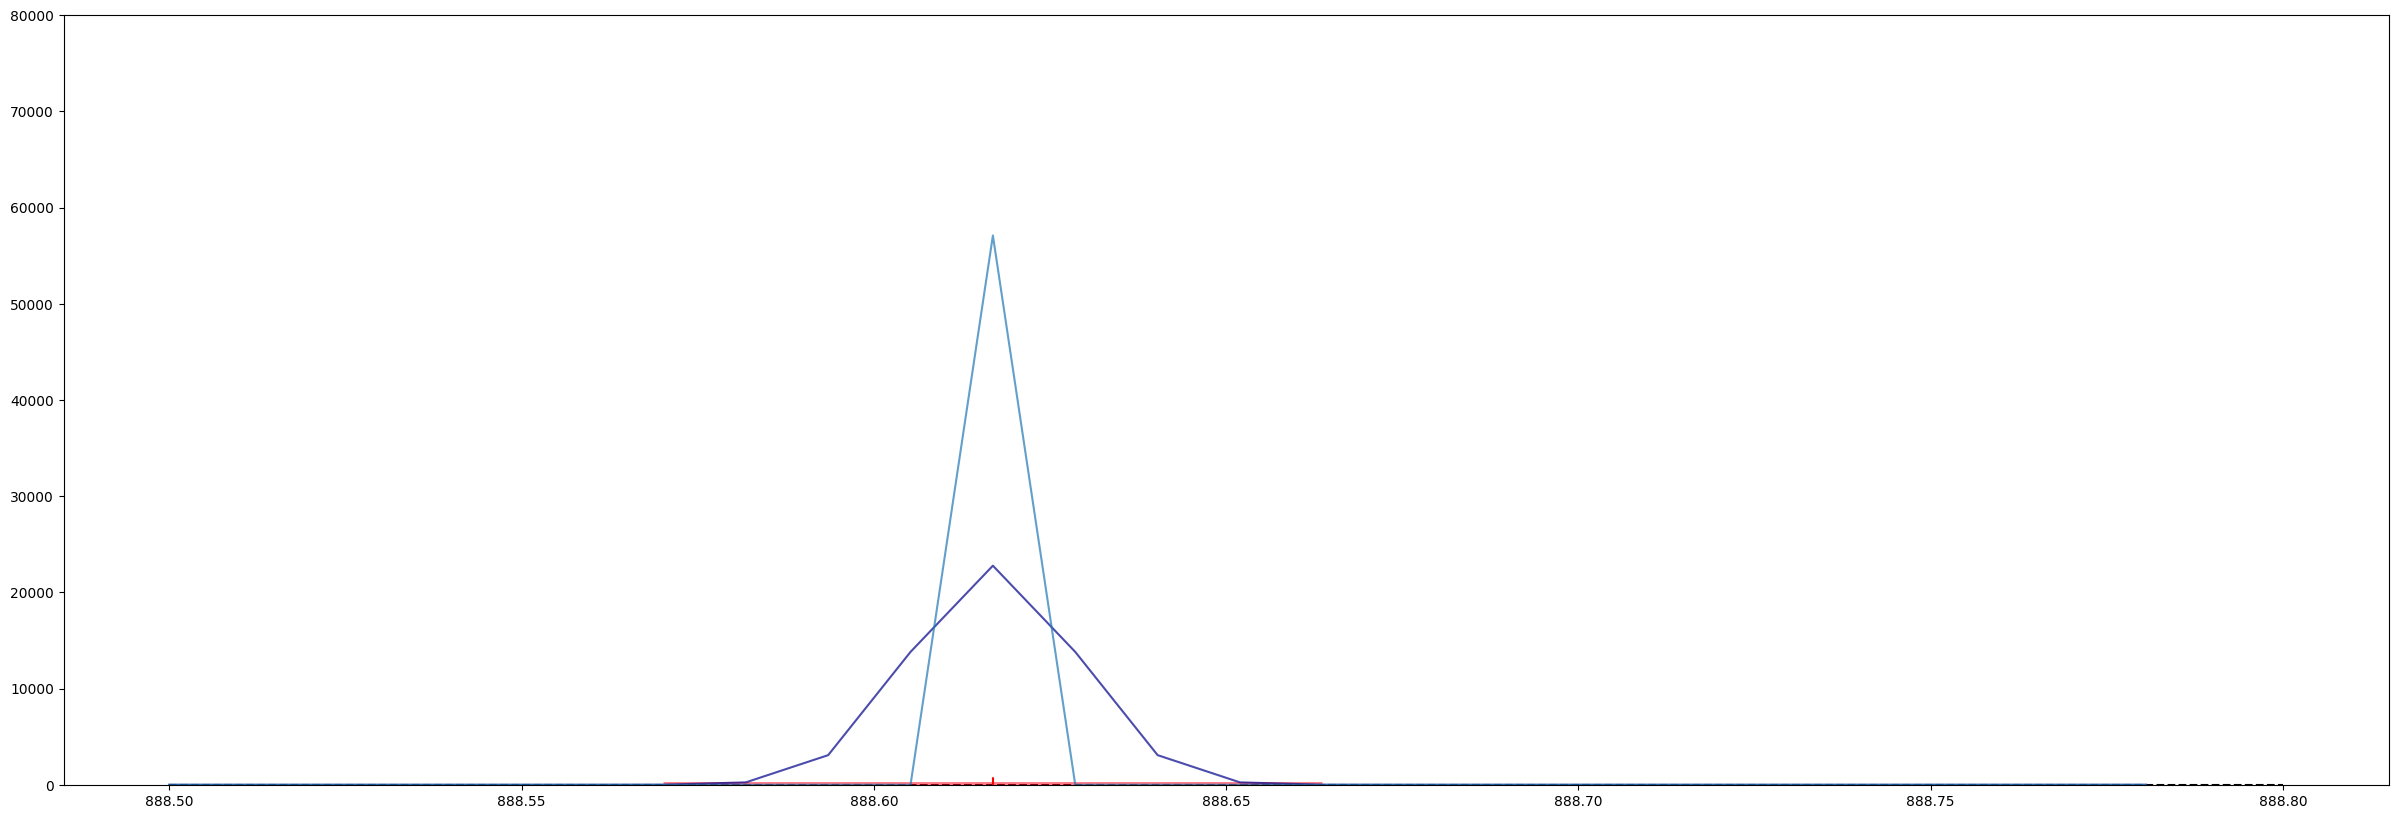

In [5]:
# smoothing on the frequency domain. for noisy mass errors, increase sigma, otherwise sigma can stay 
# a small value. use the plot_freqmz function to determine the best parameter for your dataset.
smoothing = 1.

# approximate interval refers to the size of the portion of the spectrum that is provided to the peak caller at a given instance
# if your machine throws an error, or the kernel stops, try decreasing this value
approximate_interval =.5


mzrange_test = np.array([888.5, 888.8]) # select a small window in the m/z spectrum that captures a reference compound
PF = uMAIA.vis.plot_freqmz(smz, 
                          mzrange_test, 
                          bins=True,
                          smoothing=smoothing, 
                          ylim=80000, 
                          threshold_count=threshold_count, 
                          approximate_interval=approximate_interval,
                          parallelize=True, 
                          mz_resolution=mz_resolution)

for m in PF.data_mz[PF.seeds]:
    plt.vlines(m, 0,1000,linestyle='--', color='r')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33.86it/s]


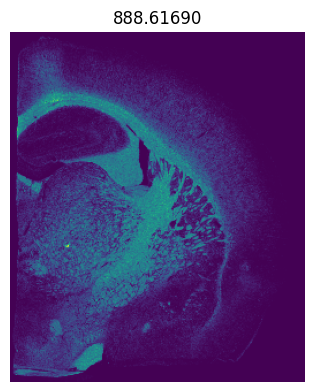

In [6]:
images = visualize_ranges_test(smz, PF)
fig = plt.figure(None, (20,10))
gs = plt.GridSpec(2,4)
for i, (mz, img) in enumerate(images.items()):
    plt.subplot(gs[i])
    plt.imshow(img)
    plt.title(mz)
    plt.axis('off')

In [7]:
smz

In [8]:
uMAIA.pf.run(directory_path="/media/duan/sda2/MALDI/Data/20251014_5FAD/MALDI/A4", # input directory for saving peak-called objects
            smz=smz, 
            spectrum_range=(130,1300), # indicate the mz spectrum you wish to image
            threshold_count=threshold_count, 
            approximate_interval=approximate_interval,
            smoothing=smoothing,
            parallelize=True,
            saveimages=True  # whether images should be saved automatically
            )

Partioning m/z space and beginning peakcalling...


  0%|                                                                                                                                                                                                                                                                  | 0/469 [00:00<?, ?it/s]

invalid mz_range
invalid mz_range
invalid mz_range


  0%|▌                                                                                                                                                                                                                                                         | 1/469 [00:00<07:31,  1.04it/s]

invalid mz_range
invalid mz_range


  0%|█                                                                                                                                                                                                                                                         | 2/469 [00:03<14:45,  1.90s/it]

invalid mz_range
invalid mz_range


  1%|█▌                                                                                                                                                                                                                                                        | 3/469 [00:06<19:02,  2.45s/it]

invalid mz_range
invalid mz_range


  1%|██▏                                                                                                                                                                                                                                                       | 4/469 [00:08<17:15,  2.23s/it]

invalid mz_range
invalid mz_range


  1%|██▋                                                                                                                                                                                                                                                       | 5/469 [00:10<17:51,  2.31s/it]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


  1%|███▏                                                                                                                                                                                                                                                      | 6/469 [00:11<12:30,  1.62s/it]

invalid mz_range
invalid mz_range
invalid mz_range


  1%|███▋                                                                                                                                                                                                                                                      | 7/469 [00:12<10:46,  1.40s/it]

invalid mz_range
invalid mz_range
invalid mz_range


  2%|████▎                                                                                                                                                                                                                                                     | 8/469 [00:12<08:06,  1.06s/it]

invalid mz_range


  2%|████▊                                                                                                                                                                                                                                                     | 9/469 [00:18<19:15,  2.51s/it]

invalid mz_range
invalid mz_range
invalid mz_range


  2%|█████▎                                                                                                                                                                                                                                                   | 10/469 [00:19<15:29,  2.02s/it]

invalid mz_range
invalid mz_range
invalid mz_range


  2%|█████▊                                                                                                                                                                                                                                                   | 11/469 [00:19<12:12,  1.60s/it]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


  3%|██████▉                                                                                                                                                                                                                                                  | 13/469 [00:20<07:32,  1.01it/s]

invalid mz_range
invalid mz_range


  3%|███████▍                                                                                                                                                                                                                                                 | 14/469 [00:22<09:25,  1.24s/it]

invalid mz_range


  3%|████████▍                                                                                                                                                                                                                                                | 16/469 [00:27<12:35,  1.67s/it]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


  4%|█████████                                                                                                                                                                                                                                                | 17/469 [00:29<13:24,  1.78s/it]

invalid mz_range
invalid mz_range
invalid mz_range


  4%|█████████▌                                                                                                                                                                                                                                               | 18/469 [00:30<11:00,  1.46s/it]

invalid mz_range
invalid mz_range
invalid mz_range


  4%|██████████                                                                                                                                                                                                                                               | 19/469 [00:32<11:42,  1.56s/it]

invalid mz_range
invalid mz_range
invalid mz_range


  4%|██████████▌                                                                                                                                                                                                                                              | 20/469 [00:34<12:41,  1.70s/it]

invalid mz_range


  4%|███████████▏                                                                                                                                                                                                                                             | 21/469 [00:40<22:53,  3.07s/it]

invalid mz_range
invalid mz_range
invalid mz_range


  5%|███████████▋                                                                                                                                                                                                                                             | 22/469 [00:41<17:32,  2.35s/it]

invalid mz_range
invalid mz_range
invalid mz_range


  5%|████████████▏                                                                                                                                                                                                                                            | 23/469 [00:41<14:02,  1.89s/it]

invalid mz_range
invalid mz_range
invalid mz_range


  5%|████████████▋                                                                                                                                                                                                                                            | 24/469 [00:43<12:22,  1.67s/it]

invalid mz_range
invalid mz_range


  5%|█████████████▎                                                                                                                                                                                                                                           | 25/469 [00:46<16:57,  2.29s/it]

invalid mz_range
invalid mz_range


  6%|█████████████▊                                                                                                                                                                                                                                           | 26/469 [00:49<17:59,  2.44s/it]

invalid mz_range


  6%|██████████████▎                                                                                                                                                                                                                                          | 27/469 [00:59<35:01,  4.75s/it]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


  6%|██████████████▊                                                                                                                                                                                                                                          | 28/469 [01:00<25:13,  3.43s/it]

invalid mz_range


  6%|███████████████▍                                                                                                                                                                                                                                         | 29/469 [01:04<26:30,  3.61s/it]

invalid mz_range
invalid mz_range
invalid mz_range


  6%|███████████████▉                                                                                                                                                                                                                                         | 30/469 [01:06<22:42,  3.10s/it]

invalid mz_range


  7%|████████████████▍                                                                                                                                                                                                                                        | 31/469 [01:11<27:08,  3.72s/it]

invalid mz_range
invalid mz_range
invalid mz_range


  7%|████████████████▉                                                                                                                                                                                                                                        | 32/469 [01:12<20:49,  2.86s/it]

invalid mz_range


  7%|█████████████████▌                                                                                                                                                                                                                                       | 33/469 [01:16<24:15,  3.34s/it]

invalid mz_range
invalid mz_range
invalid mz_range


  7%|██████████████████                                                                                                                                                                                                                                       | 34/469 [01:17<19:14,  2.65s/it]

invalid mz_range
invalid mz_range
invalid mz_range


  7%|██████████████████▌                                                                                                                                                                                                                                      | 35/469 [01:19<16:56,  2.34s/it]

invalid mz_range
invalid mz_range
invalid mz_range


  8%|███████████████████                                                                                                                                                                                                                                      | 36/469 [01:19<13:10,  1.83s/it]

invalid mz_range


  8%|███████████████████▋                                                                                                                                                                                                                                     | 37/469 [01:23<17:39,  2.45s/it]

invalid mz_range
invalid mz_range


  8%|████████████████████▏                                                                                                                                                                                                                                    | 38/469 [01:26<19:17,  2.69s/it]

invalid mz_range


  8%|████████████████████▋                                                                                                                                                                                                                                    | 39/469 [01:31<23:25,  3.27s/it]

invalid mz_range
invalid mz_range


  9%|█████████████████████▏                                                                                                                                                                                                                                   | 40/469 [01:33<21:12,  2.97s/it]

invalid mz_range
invalid mz_range
invalid mz_range


  9%|█████████████████████▊                                                                                                                                                                                                                                   | 41/469 [01:35<18:51,  2.64s/it]

invalid mz_range
invalid mz_range
invalid mz_range


  9%|██████████████████████▎                                                                                                                                                                                                                                  | 42/469 [01:36<14:56,  2.10s/it]

invalid mz_range
invalid mz_range


  9%|██████████████████████▊                                                                                                                                                                                                                                  | 43/469 [01:38<13:46,  1.94s/it]

invalid mz_range
invalid mz_range


  9%|███████████████████████▎                                                                                                                                                                                                                                 | 44/469 [01:40<15:30,  2.19s/it]

invalid mz_range


 10%|███████████████████████▉                                                                                                                                                                                                                                 | 45/469 [01:47<25:35,  3.62s/it]

invalid mz_range


 10%|████████████████████████▍                                                                                                                                                                                                                                | 46/469 [01:52<27:34,  3.91s/it]

invalid mz_range
invalid mz_range


 10%|█████████████████████████▍                                                                                                                                                                                                                               | 48/469 [01:54<16:43,  2.38s/it]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 10%|██████████████████████████                                                                                                                                                                                                                               | 49/469 [01:56<16:25,  2.35s/it]

invalid mz_range


 11%|███████████████████████████                                                                                                                                                                                                                              | 51/469 [02:10<32:16,  4.63s/it]

invalid mz_range


 11%|███████████████████████████▌                                                                                                                                                                                                                             | 52/469 [02:13<30:29,  4.39s/it]

invalid mz_range
invalid mz_range


 11%|████████████████████████████▏                                                                                                                                                                                                                            | 53/469 [02:15<24:28,  3.53s/it]

invalid mz_range
invalid mz_range


 12%|████████████████████████████▋                                                                                                                                                                                                                            | 54/469 [02:17<21:30,  3.11s/it]

invalid mz_range
invalid mz_range


 12%|█████████████████████████████▏                                                                                                                                                                                                                           | 55/469 [02:21<22:25,  3.25s/it]

invalid mz_range


 12%|█████████████████████████████▋                                                                                                                                                                                                                           | 56/469 [02:23<21:10,  3.08s/it]

invalid mz_range
invalid mz_range


 12%|██████████████████████████████▎                                                                                                                                                                                                                          | 57/469 [02:27<21:41,  3.16s/it]

invalid mz_range
invalid mz_range


 12%|██████████████████████████████▊                                                                                                                                                                                                                          | 58/469 [02:30<22:53,  3.34s/it]

invalid mz_range
invalid mz_range


 13%|███████████████████████████████▎                                                                                                                                                                                                                         | 59/469 [02:34<23:50,  3.49s/it]

invalid mz_range
invalid mz_range


 13%|████████████████████████████████▍                                                                                                                                                                                                                        | 61/469 [02:43<28:11,  4.14s/it]

invalid mz_range
invalid mz_range


 13%|████████████████████████████████▉                                                                                                                                                                                                                        | 62/469 [02:46<25:43,  3.79s/it]

invalid mz_range
invalid mz_range


 13%|█████████████████████████████████▍                                                                                                                                                                                                                       | 63/469 [02:49<23:28,  3.47s/it]

invalid mz_range
invalid mz_range


 14%|█████████████████████████████████▉                                                                                                                                                                                                                       | 64/469 [02:51<21:55,  3.25s/it]

invalid mz_range


 14%|██████████████████████████████████▌                                                                                                                                                                                                                      | 65/469 [02:56<23:52,  3.55s/it]

invalid mz_range
invalid mz_range


 14%|███████████████████████████████████                                                                                                                                                                                                                      | 66/469 [02:59<22:58,  3.42s/it]

invalid mz_range
invalid mz_range


 14%|███████████████████████████████████▌                                                                                                                                                                                                                     | 67/469 [03:02<22:02,  3.29s/it]

invalid mz_range


 14%|████████████████████████████████████                                                                                                                                                                                                                     | 68/469 [03:08<27:18,  4.08s/it]

invalid mz_range
invalid mz_range


 15%|████████████████████████████████████▋                                                                                                                                                                                                                    | 69/469 [03:12<28:06,  4.22s/it]

invalid mz_range
invalid mz_range


 15%|█████████████████████████████████████▏                                                                                                                                                                                                                   | 70/469 [03:15<26:09,  3.93s/it]

invalid mz_range
invalid mz_range


 15%|█████████████████████████████████████▋                                                                                                                                                                                                                   | 71/469 [03:21<29:08,  4.39s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 15%|██████████████████████████████████████▏                                                                                                                                                                                                                  | 72/469 [03:22<23:02,  3.48s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 16%|██████████████████████████████████████▊                                                                                                                                                                                                                  | 73/469 [03:23<17:32,  2.66s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 16%|███████████████████████████████████████▊                                                                                                                                                                                                                 | 75/469 [03:35<30:57,  4.71s/it]

invalid mz_range
invalid mz_range


 16%|████████████████████████████████████████▎                                                                                                                                                                                                                | 76/469 [03:38<28:01,  4.28s/it]

invalid mz_range
invalid mz_range


 16%|████████████████████████████████████████▉                                                                                                                                                                                                                | 77/469 [03:40<22:55,  3.51s/it]

invalid mz_range
invalid mz_range


 17%|█████████████████████████████████████████▍                                                                                                                                                                                                               | 78/469 [03:42<19:05,  2.93s/it]

invalid mz_range


 17%|█████████████████████████████████████████▉                                                                                                                                                                                                               | 79/469 [03:51<31:33,  4.85s/it]

invalid mz_range
invalid mz_range


 17%|██████████████████████████████████████████▍                                                                                                                                                                                                              | 80/469 [03:55<29:30,  4.55s/it]

invalid mz_range
invalid mz_range


 17%|███████████████████████████████████████████                                                                                                                                                                                                              | 81/469 [03:59<28:21,  4.38s/it]

invalid mz_range
invalid mz_range


 17%|███████████████████████████████████████████▌                                                                                                                                                                                                             | 82/469 [04:02<24:46,  3.84s/it]

invalid mz_rangeinvalid mz_range

invalid mz_range
invalid mz_range


 18%|████████████████████████████████████████████                                                                                                                                                                                                             | 83/469 [04:02<17:50,  2.77s/it]

invalid mz_range
invalid mz_range


 18%|████████████████████████████████████████████▌                                                                                                                                                                                                            | 84/469 [04:06<20:44,  3.23s/it]

invalid mz_range


 18%|█████████████████████████████████████████████▏                                                                                                                                                                                                           | 85/469 [04:13<28:07,  4.39s/it]

invalid mz_range
invalid mz_range


 18%|█████████████████████████████████████████████▋                                                                                                                                                                                                           | 86/469 [04:18<28:12,  4.42s/it]

invalid mz_range
invalid mz_range


 19%|██████████████████████████████████████████████▏                                                                                                                                                                                                          | 87/469 [04:22<27:48,  4.37s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 19%|██████████████████████████████████████████████▋                                                                                                                                                                                                          | 88/469 [04:22<20:21,  3.21s/it]

invalid mz_range
invalid mz_range


 19%|███████████████████████████████████████████████▎                                                                                                                                                                                                         | 89/469 [04:26<21:22,  3.37s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 19%|███████████████████████████████████████████████▊                                                                                                                                                                                                         | 90/469 [04:28<19:12,  3.04s/it]

invalid mz_range
invalid mz_range


 19%|████████████████████████████████████████████████▎                                                                                                                                                                                                        | 91/469 [04:31<18:11,  2.89s/it]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 20%|████████████████████████████████████████████████▊                                                                                                                                                                                                        | 92/469 [04:31<13:13,  2.10s/it]

invalid mz_range


 20%|█████████████████████████████████████████████████▍                                                                                                                                                                                                       | 93/469 [04:35<17:03,  2.72s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 20%|█████████████████████████████████████████████████▉                                                                                                                                                                                                       | 94/469 [04:37<15:42,  2.51s/it]

invalid mz_range
invalid mz_range


 20%|██████████████████████████████████████████████████▍                                                                                                                                                                                                      | 95/469 [04:41<18:33,  2.98s/it]

invalid mz_range
invalid mz_range


 20%|██████████████████████████████████████████████████▉                                                                                                                                                                                                      | 96/469 [04:44<18:26,  2.97s/it]

invalid mz_range
invalid mz_range


 21%|███████████████████████████████████████████████████▍                                                                                                                                                                                                     | 97/469 [04:46<15:56,  2.57s/it]

invalid mz_range
invalid mz_range


 21%|████████████████████████████████████████████████████                                                                                                                                                                                                     | 98/469 [04:47<12:25,  2.01s/it]

invalid mz_range
invalid mz_range


 21%|████████████████████████████████████████████████████▌                                                                                                                                                                                                    | 99/469 [04:50<14:01,  2.27s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 21%|████████████████████████████████████████████████████▉                                                                                                                                                                                                   | 100/469 [04:52<13:35,  2.21s/it]

invalid mz_range
invalid mz_range


 22%|█████████████████████████████████████████████████████▍                                                                                                                                                                                                  | 101/469 [04:56<16:39,  2.72s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 22%|█████████████████████████████████████████████████████▉                                                                                                                                                                                                  | 102/469 [04:58<15:54,  2.60s/it]

invalid mz_range
invalid mz_range


 22%|██████████████████████████████████████████████████████▍                                                                                                                                                                                                 | 103/469 [05:02<18:15,  2.99s/it]

invalid mz_range
invalid mz_range


 22%|██████████████████████████████████████████████████████▉                                                                                                                                                                                                 | 104/469 [05:03<15:23,  2.53s/it]

invalid mz_range


 22%|███████████████████████████████████████████████████████▌                                                                                                                                                                                                | 105/469 [05:11<24:14,  4.00s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 23%|████████████████████████████████████████████████████████                                                                                                                                                                                                | 106/469 [05:12<18:39,  3.08s/it]

invalid mz_range
invalid mz_range


 23%|████████████████████████████████████████████████████████▌                                                                                                                                                                                               | 107/469 [05:15<18:22,  3.05s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 23%|█████████████████████████████████████████████████████████                                                                                                                                                                                               | 108/469 [05:16<15:34,  2.59s/it]

invalid mz_range
invalid mz_range


 23%|█████████████████████████████████████████████████████████▋                                                                                                                                                                                              | 109/469 [05:19<16:12,  2.70s/it]

invalid mz_range
invalid mz_range


 23%|██████████████████████████████████████████████████████████▏                                                                                                                                                                                             | 110/469 [05:23<17:38,  2.95s/it]

invalid mz_range
invalid mz_range


 24%|██████████████████████████████████████████████████████████▋                                                                                                                                                                                             | 111/469 [05:26<19:01,  3.19s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 24%|███████████████████████████████████████████████████████████▏                                                                                                                                                                                            | 112/469 [05:29<17:19,  2.91s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 24%|███████████████████████████████████████████████████████████▊                                                                                                                                                                                            | 113/469 [05:31<15:37,  2.63s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 24%|████████████████████████████████████████████████████████████▎                                                                                                                                                                                           | 114/469 [05:32<14:08,  2.39s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 25%|████████████████████████████████████████████████████████████▊                                                                                                                                                                                           | 115/469 [05:34<13:18,  2.26s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 25%|█████████████████████████████████████████████████████████████▎                                                                                                                                                                                          | 116/469 [05:37<12:57,  2.20s/it]

invalid mz_range
invalid mz_range


 25%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                                          | 117/469 [05:38<12:06,  2.06s/it]

invalid mz_range
invalid mz_range


 25%|██████████████████████████████████████████████████████████████▍                                                                                                                                                                                         | 118/469 [05:39<10:11,  1.74s/it]

invalid mz_range
invalid mz_range


 25%|██████████████████████████████████████████████████████████████▉                                                                                                                                                                                         | 119/469 [05:42<11:26,  1.96s/it]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 26%|███████████████████████████████████████████████████████████████▍                                                                                                                                                                                        | 120/469 [05:42<08:42,  1.50s/it]

invalid mz_range
invalid mz_range


 26%|███████████████████████████████████████████████████████████████▉                                                                                                                                                                                        | 121/469 [05:45<10:44,  1.85s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 26%|████████████████████████████████████████████████████████████████▌                                                                                                                                                                                       | 122/469 [05:46<09:45,  1.69s/it]

invalid mz_range
invalid mz_range


 26%|█████████████████████████████████████████████████████████████████                                                                                                                                                                                       | 123/469 [05:50<13:43,  2.38s/it]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 26%|█████████████████████████████████████████████████████████████████▌                                                                                                                                                                                      | 124/469 [05:50<10:10,  1.77s/it]

invalid mz_range
invalid mz_range


 27%|██████████████████████████████████████████████████████████████████                                                                                                                                                                                      | 125/469 [05:54<13:25,  2.34s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 27%|██████████████████████████████████████████████████████████████████▋                                                                                                                                                                                     | 126/469 [05:56<12:24,  2.17s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 27%|███████████████████████████████████████████████████████████████████▏                                                                                                                                                                                    | 127/469 [05:57<10:29,  1.84s/it]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 28%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                   | 129/469 [06:02<12:32,  2.21s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 28%|████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                   | 130/469 [06:03<11:07,  1.97s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 28%|█████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                  | 131/469 [06:05<10:32,  1.87s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 28%|█████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                  | 132/469 [06:06<09:12,  1.64s/it]

invalid mz_range
invalid mz_range


 28%|██████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                 | 133/469 [06:09<10:38,  1.90s/it]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 29%|██████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                 | 134/469 [06:09<08:04,  1.45s/it]

invalid mz_range
invalid mz_range


 29%|███████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                | 135/469 [06:11<09:34,  1.72s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 29%|███████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                | 136/469 [06:12<08:33,  1.54s/it]

invalid mz_range
invalid mz_range


 29%|████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                               | 137/469 [06:14<08:19,  1.50s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 29%|████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                               | 138/469 [06:14<06:28,  1.17s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 30%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                              | 139/469 [06:15<05:41,  1.03s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 30%|██████████████████████████████████████████████████████████████████████████                                                                                                                                                                              | 140/469 [06:16<06:02,  1.10s/it]

invalid mz_range
invalid mz_range


 30%|██████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                             | 141/469 [06:19<08:50,  1.62s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 30%|███████████████████████████████████████████████████████████████████████████                                                                                                                                                                             | 142/469 [06:20<07:43,  1.42s/it]

invalid mz_range
invalid mz_range


 30%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                            | 143/469 [06:21<06:50,  1.26s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 31%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                           | 144/469 [06:21<05:28,  1.01s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 31%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                           | 145/469 [06:22<04:57,  1.09it/s]

invalid mz_range
invalid mz_range
invalid mz_range


 31%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                          | 146/469 [06:23<05:09,  1.04it/s]

invalid mz_range
invalid mz_range
invalid mz_range


 31%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                          | 147/469 [06:24<04:28,  1.20it/s]

invalid mz_range
invalid mz_range
invalid mz_range


 32%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                         | 148/469 [06:24<03:54,  1.37it/s]

invalid mz_range
invalid mz_range


 32%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                         | 149/469 [06:25<04:42,  1.13it/s]

invalid mz_range
invalid mz_range
invalid mz_range


 32%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                        | 150/469 [06:26<04:29,  1.18it/s]

invalid mz_range


 32%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                        | 151/469 [06:32<12:04,  2.28s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 32%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                       | 152/469 [06:32<09:31,  1.80s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 33%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                       | 153/469 [06:33<07:26,  1.41s/it]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 33%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                      | 155/469 [06:34<05:47,  1.11s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 33%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                     | 156/469 [06:35<05:27,  1.04s/it]

invalid mz_range
invalid mz_range


 33%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                     | 157/469 [06:37<06:43,  1.29s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 34%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                    | 158/469 [06:38<06:03,  1.17s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 34%|████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                    | 159/469 [06:39<05:21,  1.04s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 34%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                   | 160/469 [06:40<04:52,  1.05it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 35%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                  | 162/469 [06:40<03:25,  1.49it/s]

invalid mz_range
invalid mz_range


 35%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                 | 163/469 [06:43<05:34,  1.09s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 35%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                 | 164/469 [06:43<04:54,  1.03it/s]

invalid mz_range
invalid mz_range
invalid mz_range


 35%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                | 166/469 [06:44<03:35,  1.41it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 36%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                               | 167/469 [06:44<02:46,  1.82it/s]

invalid mz_range
invalid mz_range
invalid mz_range


 36%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                               | 168/469 [06:45<03:06,  1.61it/s]

invalid mz_range
invalid mz_range


 36%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                              | 169/469 [06:46<03:27,  1.45it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 36%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                              | 170/469 [06:46<02:51,  1.74it/s]

invalid mz_range
invalid mz_range


 36%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 171/469 [06:47<03:32,  1.40it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 37%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 172/469 [06:48<02:50,  1.74it/s]

invalid mz_range
invalid mz_range


 37%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                            | 173/469 [06:50<04:48,  1.03it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 38%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                           | 176/469 [06:52<04:02,  1.21it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 38%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 177/469 [06:52<03:09,  1.54it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 38%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                        | 180/469 [06:54<02:46,  1.74it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 39%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                        | 181/469 [06:54<02:26,  1.96it/s]

invalid mz_range
invalid mz_range
invalid mz_range


 39%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                       | 182/469 [06:54<02:14,  2.13it/s]

invalid mz_rangeinvalid mz_range

invalid mz_range


 39%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 183/469 [06:55<02:20,  2.04it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 39%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                      | 185/469 [06:56<01:55,  2.47it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 40%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 188/469 [06:56<01:30,  3.10it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 41%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 190/469 [06:57<01:10,  3.95it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 41%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                   | 191/469 [06:57<01:39,  2.78it/s]

invalid mz_range
invalid mz_range
invalid mz_range


 41%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                  | 192/469 [06:58<01:36,  2.87it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 41%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                 | 194/469 [06:58<01:17,  3.55it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 42%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 196/469 [06:58<00:54,  5.05it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 42%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                               | 198/469 [06:59<00:49,  5.51it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                            | 203/469 [06:59<00:30,  8.67it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 206/469 [06:59<00:32,  8.10it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                         | 210/469 [07:00<00:26,  9.65it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                       | 213/469 [07:00<00:21, 11.75it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                     | 217/469 [07:01<00:27,  9.20it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 220/469 [07:01<00:33,  7.44it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 223/469 [07:01<00:23, 10.28it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                | 227/469 [07:03<00:48,  5.00it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                               | 229/469 [07:04<01:18,  3.04it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 235/469 [07:05<01:06,  3.50it/s]

invalid mz_range
invalid mz_range


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 236/469 [07:08<02:01,  1.91it/s]

invalid mz_range
invalid mz_range
invalid mz_range


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                          | 237/469 [07:09<02:20,  1.65it/s]

invalid mz_range
invalid mz_range
invalid mz_range


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                          | 238/469 [07:10<02:48,  1.37it/s]

invalid mz_range
invalid mz_range
invalid mz_range


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                         | 239/469 [07:12<03:33,  1.08it/s]

invalid mz_range
invalid mz_range
invalid mz_range


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 242/469 [07:14<02:37,  1.44it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                       | 244/469 [07:14<01:51,  2.02it/s]

invalid mz_range
invalid mz_range
invalid mz_range


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                      | 245/469 [07:15<01:44,  2.15it/s]

invalid mz_range
invalid mz_range
invalid mz_range


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                      | 246/469 [07:16<02:51,  1.30it/s]

invalid mz_range
invalid mz_range


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                     | 247/469 [07:20<05:22,  1.45s/it]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                    | 248/469 [07:20<04:20,  1.18s/it]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 250/469 [07:21<02:33,  1.43it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                   | 251/469 [07:21<01:58,  1.84it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 254/469 [07:23<02:27,  1.46it/s]

invalid mz_range
invalid mz_range


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                 | 255/469 [07:25<03:29,  1.02it/s]

invalid mz_range
invalid mz_range


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                | 257/469 [07:27<02:53,  1.23it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 258/469 [07:27<02:15,  1.55it/s]

invalid mz_range
invalid mz_range
invalid mz_range


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 259/469 [07:29<03:25,  1.02it/s]

invalid mz_range
invalid mz_range


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 260/469 [07:31<04:29,  1.29s/it]

invalid mz_range
invalid mz_range


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 261/469 [07:32<03:52,  1.12s/it]

invalid mz_rangeinvalid mz_range
invalid mz_range

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                            | 264/469 [07:32<01:59,  1.72it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                           | 265/469 [07:36<04:28,  1.32s/it]

invalid mz_range
invalid mz_range


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                           | 266/469 [07:37<04:17,  1.27s/it]

invalid mz_range
invalid mz_range
invalid mz_range


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 267/469 [07:37<03:34,  1.06s/it]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 270/469 [07:38<01:57,  1.69it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 271/469 [07:38<01:43,  1.92it/s]

invalid mz_range
invalid mz_range
invalid mz_range


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                        | 272/469 [07:39<01:57,  1.68it/s]

invalid mz_rangeinvalid mz_range

invalid mz_range


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 276/469 [07:40<00:58,  3.28it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 277/469 [07:40<01:08,  2.80it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 279/469 [07:41<00:58,  3.23it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 282/469 [07:43<01:33,  1.99it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 286/469 [07:43<00:52,  3.51it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 289/469 [07:45<01:03,  2.81it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 291/469 [07:45<00:51,  3.43it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 292/469 [07:45<00:54,  3.26it/s]

invalid mz_range
invalid mz_range
invalid mz_range


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 293/469 [07:46<01:05,  2.71it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 298/469 [07:47<00:33,  5.15it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 299/469 [07:47<00:33,  5.09it/s]

invalid mz_range
invalid mz_range
invalid mz_range


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 300/469 [07:49<01:23,  2.02it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 301/469 [07:49<01:17,  2.18it/s]

invalid mz_range
invalid mz_range
invalid mz_range


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 302/469 [07:50<01:48,  1.53it/s]

invalid mz_range
invalid mz_range
invalid mz_range


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 303/469 [07:52<02:43,  1.01it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 306/469 [07:53<01:20,  2.03it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 310/469 [07:53<00:38,  4.09it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 315/469 [07:55<00:42,  3.62it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 324/469 [07:55<00:15,  9.38it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_ran

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 350/469 [07:55<00:04, 28.30it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_ran

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 394/469 [07:55<00:00, 82.66it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_ran

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 463/469 [07:56<00:00, 171.19it/s]

invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_range
invalid mz_ran

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [07:56<00:00,  1.02s/it]


Creating dataframe...


  0%|                                                                                                                                                                                                                                                                 | 0/2727 [00:00<?, ?it/s]/media/duan/sda2/MALDI/software/uMAIA/uMAIA/peak_finding/_run.py:213: RuntimeWarning: invalid value encountered in scalar divide
  percent_1_hit = np.sum(S_selected == 1.) / np.sum(S_selected >= 1.) * 100
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2727/2727 [00:03<00:00, 772.03it/s]


DataFrame created successfully
Removing temporary storage
Saving images...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 34.60it/s]


Complete


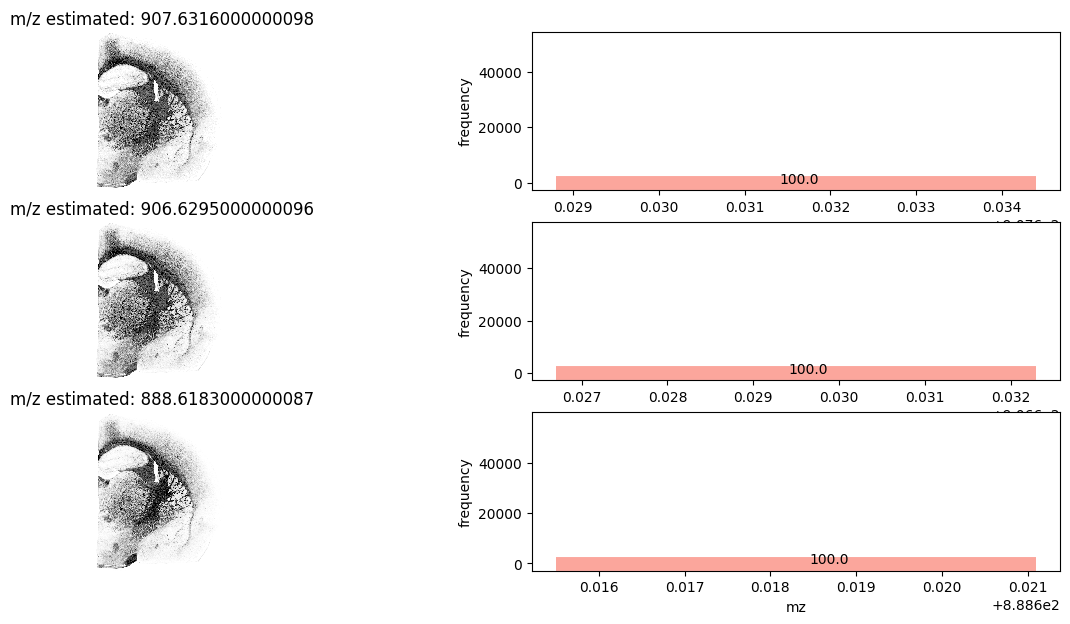

In [9]:
df_ranges = pd.read_csv("/media/duan/sda2/MALDI/Data/20251014_5FAD/MALDI/A4/ranges.csv", index_col=0)

adduct_H = -1.0078
adduct_H2O = - 18.0150 - 1.0078
s_mz = 907.641851


fig, mz_images = uMAIA.vis.image_mz(smz, df=df_ranges, normalize = None,
                             mz_list=[s_mz, s_mz + adduct_H, s_mz + adduct_H2O], 
                             cmap='Greys',figsize=(15,7),
                             img_shape=smz.img_shape, limit=0.01,clip=99,
                            )

In [10]:
import scanpy as sc
import numpy as np

In [11]:
adata = sc.read_h5ad("/media/duan/sda2/MALDI/Data/20251014_5FAD/MALDI/A4/images.h5ad")
adata

AnnData object with n_obs × n_vars = 77824 × 1000
    var: '0'
    uns: 'img_shape'

In [12]:
X, Y = adata.uns['img_shape']

In [13]:
spatials = []

for x in range(X):
    for y in range(Y):
        spatials.append([y,x])

In [14]:
adata.obsm['spatial'] = np.array(spatials)

In [15]:
adata.var.columns = ['m/z']
adata.var_names = adata.var['m/z'].round(5).map('{:.5f}'.format)

/home/duan/miniconda3/envs/uMAIA_env/lib/python3.11/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: Some cells have zero counts
  return fn(*args_all, **kw)


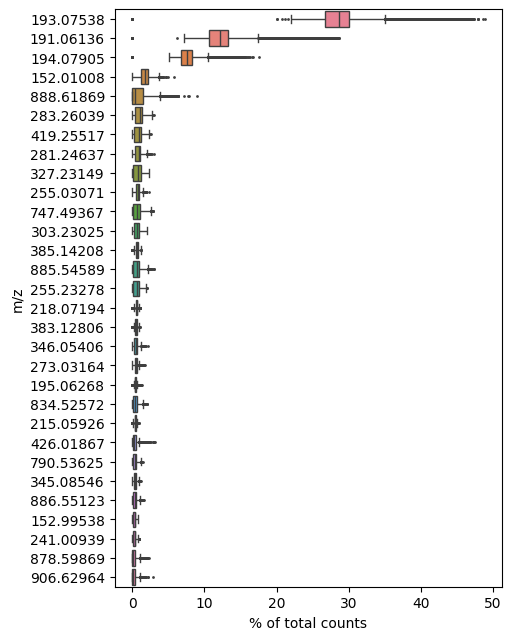

In [16]:
sc.pl.highest_expr_genes(adata)

In [17]:
X/35

8.685714285714285

In [18]:
Y/35

7.314285714285714

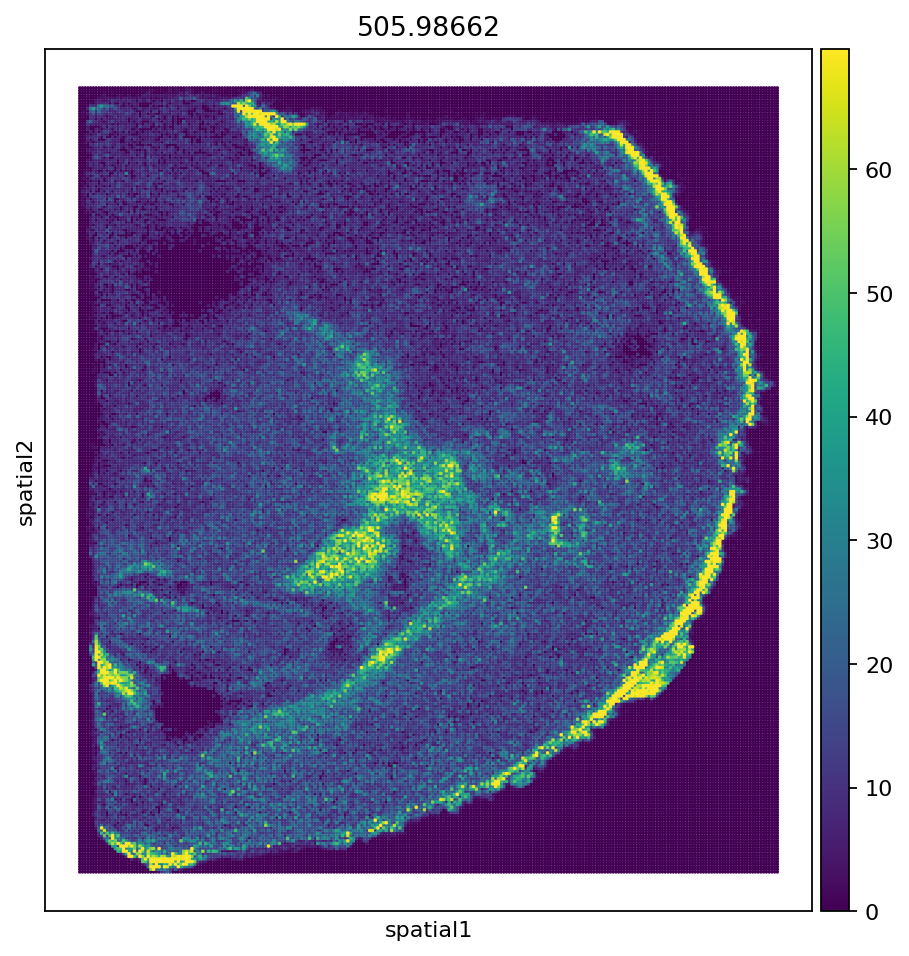

In [22]:
sc.set_figure_params(figsize = (6.8,7), scanpy = False)
sc.pl.embedding(adata, basis = 'spatial', color = '505.98662', vmax = 'p99', size = 10)

In [21]:
adata.write_h5ad("MALDI/9AA_A4_uMAIA_raw.h5ad")